In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import h2o
from h2o.targetencoder import TargetEncoder

import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
notebook_tic = time.time()

In [3]:
h2o.init(ip="127.0.0.1", max_mem_size_GB = 200, nthreads = 5)

Checking whether there is an H2O instance running at http://127.0.0.1:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-b04); OpenJDK 64-Bit Server VM (build 25.212-b04, mixed mode)
  Starting server from /workspaces/sefik/.local/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjn2kbjn2
  JVM stdout: /tmp/tmpjn2kbjn2/h2o_sefik_started_from_python.out
  JVM stderr: /tmp/tmpjn2kbjn2/h2o_sefik_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Istanbul
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,2 months and 13 days
H2O cluster name:,H2O_from_python_sefik_rkz0dr
H2O cluster total nodes:,1
H2O cluster free memory:,177.8 Gb
H2O cluster total cores:,72
H2O cluster allowed cores:,5
H2O cluster status:,"accepting new members, healthy"


In [4]:
tic = time.time()

train = pd.read_csv('train.csv')
print("train loaded")
metadata = pd.read_csv('building_metadata.csv')
print("metadata loaded")
train = train.merge(metadata, on="building_id", how="left")
print("train and metadata merged")

weather = pd.read_csv('weather_train.csv')
print("weather loaded")
train = train.merge(weather, on=["site_id", "timestamp"], how="left")
print("train and weather merged")

toc = time.time()

print(toc - tic," seconds")

train loaded
metadata loaded
train and metadata merged
weather loaded
train and weather merged
16.299173831939697  seconds


In [5]:
#very large target causes trouble for rmsle
#restore this with np.expm1 in prediction
train['meter_reading'] = np.log1p(train['meter_reading']).astype(np.float32)

In [6]:
tic = time.time()

hf_train = h2o.H2OFrame(train) # 4 minutes avg time

toc = time.time()
print(toc-tic," seconds")

Parse progress: |█████████████████████████████████████████████████████████| 100%
231.35332608222961  seconds


In [7]:
target_label = 'meter_reading'

In [8]:
#we no longer need to store pandas data frame
del train

In [9]:
hf_train.head()

building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0,0,Education,7432,2008,nan,25,6,20,nan,1019.7,0,0
1,0,2016-01-01 00:00:00,0,0,Education,2720,2004,nan,25,6,20,nan,1019.7,0,0
2,0,2016-01-01 00:00:00,0,0,Education,5376,1991,nan,25,6,20,nan,1019.7,0,0
3,0,2016-01-01 00:00:00,0,0,Education,23685,2002,nan,25,6,20,nan,1019.7,0,0
4,0,2016-01-01 00:00:00,0,0,Education,116607,1975,nan,25,6,20,nan,1019.7,0,0
5,0,2016-01-01 00:00:00,0,0,Education,8000,2000,nan,25,6,20,nan,1019.7,0,0
6,0,2016-01-01 00:00:00,0,0,Lodging/residential,27926,1981,nan,25,6,20,nan,1019.7,0,0
7,0,2016-01-01 00:00:00,0,0,Education,121074,1989,nan,25,6,20,nan,1019.7,0,0
8,0,2016-01-01 00:00:00,0,0,Education,60809,2003,nan,25,6,20,nan,1019.7,0,0
9,0,2016-01-01 00:00:00,0,0,Office,27000,2010,nan,25,6,20,nan,1019.7,0,0


# Expand features

In [10]:
def expandFeatures(df):
    df['year'] = df['timestamp'].year()
    df['month'] = df['timestamp'].month()
    df['day'] = df['timestamp'].day()
    df['hour'] = df['timestamp'].hour()
    df['weekday'] = df['timestamp'].dayOfWeek()
    
    #-------------------------------
    
    df['square_feet'] = df['square_feet'].log()
    
    df['year_built'] = df['year_built'].asnumeric()
    df['year_built'] = df[df['year_built'] >= 0]['year_built'].max() - df['year_built']
    
    df['sea_level_pressure'] = df['sea_level_pressure']- df[df['sea_level_pressure'] >= 0]['sea_level_pressure'].min()
    
    #-------------------------------
    
    df = df.drop('timestamp')
    
    return df

In [11]:
tic = time.time()
hf_train = expandFeatures(hf_train)
toc = time.time()
print("Features expanded for train (",toc-tic," seconds)")

Features expanded for train ( 10.131810665130615  seconds)


In [12]:
hf_train.shape

(20216100, 20)

In [13]:
categorical_features = ['meter', 'primary_use', 'site_id'
                        #, 'building_id'
                       ]

In [14]:
#for key, col_type in hf_train.types.items():
for key in hf_train.types:
    col_type = hf_train.types[key]
    if key in categorical_features:
        hf_train[key] = hf_train[key].asfactor()
    else:
        hf_train[key] = hf_train[key].asnumeric()

In [15]:
hf_train.describe()

Rows:20216100
Cols:20




,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekday
type,int,enum,real,enum,enum,real,int,int,real,int,real,int,real,int,real,int,int,int,int,int
mins,0.0,,0.0,,,5.645446897643238,0.0,0.0,-28.9,0.0,-35.0,-1.0,0.0,0.0,0.0,2016.0,1.0,1.0,0.0,0.0
mean,799.2780003561518,,4.145765666717879,,,11.03941325515514,19.806972660404327,16.275637684815578,15.987952737456638,5.436303886506298,7.747429309861423,0.796415538714005,47.88548737120429,173.0151039172268,3.3775245829801133,2016.0,6.5784530646366015,15.761227041813209,11.50231755877741,3.00695762288473
maxs,1448.0,,16.902212142944336,,,13.681979165339751,116.0,18.0,47.2,10.0,26.1,343.0,77.29999999999995,360.0,19.0,2016.0,12.0,31.0,23.0,6.0
sigma,426.9133090350083,,2.146220046542852,,,1.180525124823705,30.74401289346902,4.458282278362877,10.947292617476561,4.403410359072409,10.178666840106992,7.468996644451527,7.060539185923556,114.05736420869192,2.2656939441528188,0.0,3.436661773246548,8.820534618755353,6.922017339280046,1.9971914946353297
zeros,8784,,1873976,,,0,12127645,934303,141477,5752501,331655,14517573,35,2373540,2384761,0,0,0,842381,2871227
missing,0,0,0,0,0,0,0,0,96658,0,100140,3749023,1231669,1449048,143676,0,0,0,0,0
0,0.0,0,0.0,0,Education,8.913550280493675,10.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0
1,1.0,0,0.0,0,Education,7.908387159290043,14.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0
2,2.0,0,0.0,0,Education,8.589699882202986,27.0,18.0,25.0,6.0,20.0,nan,51.5,0.0,0.0,2016.0,1.0,1.0,0.0,4.0


In [16]:
feature_names = []

for i in hf_train.columns:
    if i != target_label:
        feature_names.append(i)

In [17]:
hf_train.head()

building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,weekday
0,0,0,0,Education,8.91355,10,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
1,0,0,0,Education,7.90839,14,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
2,0,0,0,Education,8.5897,27,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
3,0,0,0,Education,10.0726,16,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
4,0,0,0,Education,11.6666,43,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
5,0,0,0,Education,8.9872,18,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
6,0,0,0,Lodging/residential,10.2373,37,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
7,0,0,0,Education,11.7042,29,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
8,0,0,0,Education,11.0155,15,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4
9,0,0,0,Office,10.2036,8,18,25,6,20,nan,51.5,0,0,2016,1,1,0,4


# Train Test and Validation Split

In [18]:
#70% train, 15% test, 15% validation
tic = time.time()
train, test, validation = hf_train.split_frame(ratios=[0.70, 0.15], seed=17)
toc = time.time()

print(toc -tic," seconds")

5.226664781570435  seconds


# H2O XGBoost

In [19]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

In [20]:
model = H2OXGBoostEstimator(
    ntrees = 250
    , max_depth = 10
    , learn_rate = 0.01
    , seed = 4241
    , stopping_rounds = 50
    , stopping_metric = "RMSE"
)

In [21]:
tic = time.time()

model.train(x=feature_names, y=target_label
          , training_frame=train, validation_frame = validation)

toc = time.time()

print(toc-tic," seconds")

xgboost Model Build progress: |███████████████████████████████████████████| 100%
151.66560578346252  seconds


In [22]:
model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1573044307005_1


Model Summary: 

,,number_of_trees
0,,250.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 1.513894257926021
RMSE: 1.2304041035066573
MAE: 0.906436262244084
RMSLE: 0.39415706755299823
Mean Residual Deviance: 1.513894257926021

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 1.5171660020332272
RMSE: 1.231732926422456
MAE: 0.9069642599346224
RMSLE: 0.39460045436922103
Mean Residual Deviance: 1.5171660020332272

Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-11-06 15:49:44,8.037 sec,0.0,4.230700,3.745262,17.898820,4.230314,3.745079,17.895554
1,,2019-11-06 15:50:34,58.345 sec,106.0,1.931649,1.665883,3.731268,1.932006,1.666189,3.732645
2,,2019-11-06 15:51:31,1 min 55.068 sec,250.0,1.230404,0.906436,1.513894,1.231733,0.906964,1.517166



Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,square_feet,807352896.0,1.000000,0.356992
1,building_id,276280576.0,0.342205,0.122165
2,air_temperature,198034384.0,0.245289,0.087566
3,month,142661072.0,0.176702,0.063081
4,meter.0,98116376.0,0.121528,0.043385
5,meter.1,69170976.0,0.085676,0.030586
6,site_id.0,69043184.0,0.085518,0.030529
7,year_built,68059064.0,0.084299,0.030094
8,meter.3,59861144.0,0.074145,0.026469
9,meter.2,53535272.0,0.066310,0.023672



See the whole table with table.as_data_frame()


# Feature Importance

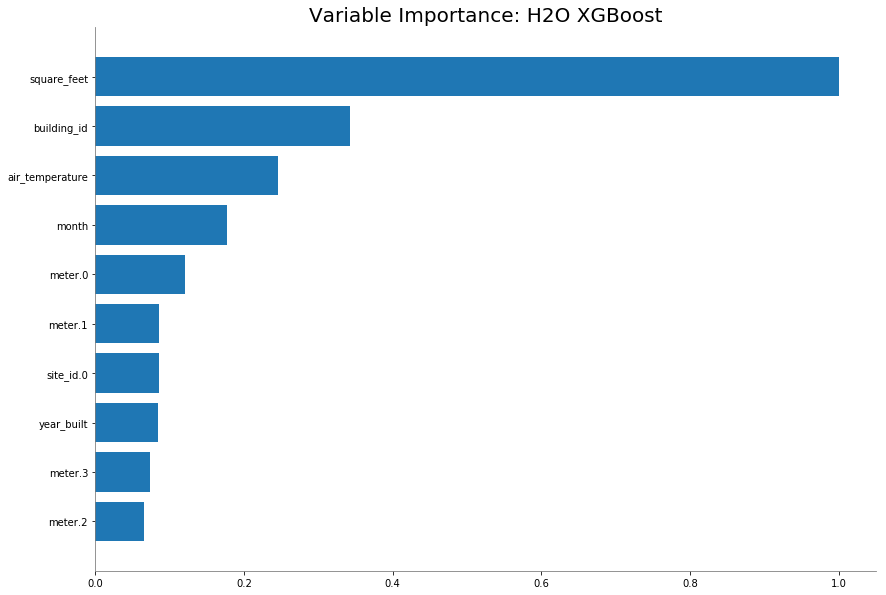

In [32]:
variables = model._model_json['output']['variable_importances']['variable']
scaled_importance = model._model_json['output']['variable_importances']['scaled_importance']

model.varimp_plot()

In [24]:
variables[0:15]

['square_feet',
 'building_id',
 'air_temperature',
 'month',
 'meter.0',
 'meter.1',
 'site_id.0',
 'year_built',
 'meter.3',
 'meter.2',
 'site_id.14',
 'dew_temperature',
 'floor_count',
 'site_id.5',
 'primary_use.Education']

# Performance

In [25]:
tic = time.time()
test_perf = model.model_performance(test)
toc = time.time()
print(toc-tic," seconds")

20.084758281707764  seconds


In [26]:
test_perf


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 1.5147561717455036
RMSE: 1.2307543100657838
MAE: 0.906216992093485
RMSLE: 0.3941096711187276
Mean Residual Deviance: 1.5147561717455036


# Prediction

In [27]:
tic = time.time()
predictions = model.predict(test_data = test)
toc = time.time()
print(toc-tic," seconds")

xgboost prediction progress: |████████████████████████████████████████████| 100%
20.347606420516968  seconds


In [28]:
predictions['predict'] = predictions['predict'].expm1()

In [29]:
predictions.tail()

predict
292.831
26.3324
12.5766
115.687
196.108
451.556
486.821
129.52
8.80708
67.144


In [30]:
notebook_toc = time.time()

In [31]:
print("notebook completed in ",notebook_toc - notebook_tic," seconds")

notebook completed in  463.9202163219452  seconds
